# Exploratory data analysis 1

This notebook demonstrates that there are less images per lap with higher speeds and 
that the ground truth turning angles tend to have more extreme values with higher speeds.

## Setup
- Download and unpack training data
- Create DonkeyCar project and load configuration

In [5]:
%load_ext autoreload
%autoreload 2
import os
# do we have the correct env loaded?
assert 'donkey' == os.environ['CONDA_DEFAULT_ENV'], os.environ['CONDA_DEFAULT_ENV']

AssertionError: donkey2

In [ ]:
![ ! -d "data/" ] && \
mkdir data && \
curl -L "https://www.dropbox.com/s/eltelvjt12a4ny1/data.zip?dl=1" --output data/data.zip && \
unzip data/data.zip -d data

In [ ]:
![ ! -d "mycar/" ] && \
donkey createcar --path mycar && \
cp config/myconfig.py mycar/

In [6]:
import sys
sys.path.append('donkeycar')
sys.path.append('src')

In [7]:
import numpy as np
import donkeycar as dk
cfg = dk.load_config(config_path='mycar/config.py')
cfg.SEQUENCE_LENGTH = 0

loading config file: mycar/config.py
loading personal config over-rides from myconfig.py


## Is the driving speed of .9 actually different from the slower speeds of .85 and .8?
Prove that the driving speed of .9 actually was faster by
showing that there are less images per lap with higher speeds using image difference graphs

### Load images

In [8]:
from dataloader import load_records
from collections import OrderedDict


tubs = [
    '1-1-CC-80',
    '2-1-CW-80',
    '4-1-CC-80',
    '1-3-CC-85',
    '2-3-CW-85',
    '3-3-CW-85',
    '4-3-CC-85',
    '1-2-CC-90',
    '2-2-CW-90',
    '3-2-CW-90',
    '4-2-CC-90',
]

tub_images = OrderedDict()

for tub_name in tubs:
    tub_images[tub_name] = [r.image() for r in load_records(tub_name, cfg, 'data/')]


Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/1-1-CC-80/catalog_4.catalog


INFO:donkeycar.pipeline.types:Loading tubs from paths ['data/1-1-CC-80']
INFO:donkeycar.pipeline.types:Loading tubs from paths ['data/2-1-CW-80']


Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/2-1-CW-80/catalog_4.catalog


INFO:donkeycar.pipeline.types:Loading tubs from paths ['data/4-1-CC-80']


Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/4-1-CC-80/catalog_5.catalog


INFO:donkeycar.pipeline.types:Loading tubs from paths ['data/1-3-CC-85']


Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/1-3-CC-85/catalog_4.catalog


INFO:donkeycar.pipeline.types:Loading tubs from paths ['data/2-3-CW-85']


Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/2-3-CW-85/catalog_6.catalog


INFO:donkeycar.pipeline.types:Loading tubs from paths ['data/3-3-CW-85']


Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/3-3-CW-85/catalog_4.catalog


INFO:donkeycar.pipeline.types:Loading tubs from paths ['data/4-3-CC-85']


Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/4-3-CC-85/catalog_4.catalog


INFO:donkeycar.pipeline.types:Loading tubs from paths ['data/1-2-CC-90']


Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/1-2-CC-90/catalog_4.catalog


INFO:donkeycar.pipeline.types:Loading tubs from paths ['data/2-2-CW-90']


Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/2-2-CW-90/catalog_2.catalog


INFO:donkeycar.pipeline.types:Loading tubs from paths ['data/3-2-CW-90']


Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/3-2-CW-90/catalog_6.catalog


INFO:donkeycar.pipeline.types:Loading tubs from paths ['data/4-2-CC-90']


Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/4-2-CC-90/catalog_7.catalog


### Count the number of laps for each tub

In [9]:
from skimage.metrics import mean_squared_error

def mse(image1, image2):
    return np.array((image1 - image2)**2).mean()

def rmse(image1, image2):
    return np.sqrt(mse(image1, image2))

def get_diffs(images):
    return [rmse(images[0], img) for img in images]

def get_counts(diffs, lower_bound=8.8, upper_bound=9.75):
    flip = False
    counts = []
    for i, d in enumerate(diffs):
        if not flip and d < lower_bound and (len(counts) == 0 or i - counts[-1] > 165):
            flip = True
            counts.append(i)
        if flip and d > upper_bound:
            flip = False
    return np.array(counts)

def get_lengths(counts):
    return counts[1:] - counts[:-1]

def get_lengths_and_mean(images, lower_bound, upper_bound):
    diffs = get_diffs(images)
    counts = get_counts(diffs, lower_bound, upper_bound)
    lengths = get_lengths(counts)
    print(f'counts {counts} len {lengths}, mean {np.mean(lengths)}')
    assert np.mean(lengths) != np.nan
    return lengths, int(np.mean(lengths))

In [10]:
tub_bounds = [
    ('1-2-CC-90',    (9.55, 10)),
    ('2-2-CW-90',    (9.28, 10)),
    ('3-2-CW-90',    (9.25, 9.8)),
    ('4-2-CC-90',    (8.8, 10)),
    ('1-3-CC-85',    (8.8, 9.75)),
    ('2-3-CW-85',    (9.35, 10.0)),
    ('3-3-CW-85',    (8.75, 10)),
    ('4-3-CC-85',    (9.3, 10)),
    ('1-1-CC-80',    (9.25, 10.1)),
    ('2-1-CW-80',    (9.25, 10.4)),
    ('4-1-CC-80',    (8.75, 9.5)),
]

average_lap_frames = {}
image_counts = []
lengths_counts = []


for name, (lower_bound, upper_bound) in tub_bounds:
    images = tub_images[name]
    image_counts.append(len(images))
    print(name)
    lengths, mean = get_lengths_and_mean(images, lower_bound, upper_bound)
    lengths_counts.append(lengths)
    average_lap_frames[name] = mean

average_lap_frames

1-2-CC-90
counts [   0  290  536  808 1057 1310 1563 1756 2015 2286 2521 2767 3031 3276
 3526 3776 4017 4293 4535] len [290 246 272 249 253 253 193 259 271 235 246 264 245 250 250 241 276 242], mean 251.94444444444446
2-2-CW-90
counts [  0 225 403 626 798 985] len [225 178 223 172 187], mean 197.0
3-2-CW-90
counts [   0  222  527  758  944 1113 1366 1583 1917 2257 2524 2810 3082 3390
 3683 3876 4147 4505 4874] len [222 305 231 186 169 253 217 334 340 267 286 272 308 293 193 271 358 369], mean 270.77777777777777
4-2-CC-90
counts [   0  260  440  735  957 1213 1490 1673 1899 2274 2609 2947 3202 3431
 3663 3896 4116 4345 4663 4929 5213 5445 5662 5886 6125] len [260 180 295 222 256 277 183 226 375 335 338 255 229 232 233 220 229 318
 266 284 232 217 224 239], mean 255.20833333333334
1-3-CC-85
counts [   0  351  669 1065 1488 1918 2345 2751 3212 3673 4147] len [351 318 396 423 430 427 406 461 461 474], mean 414.7
2-3-CW-85
counts [   0  430  817 1219 1632 2030 2343 2867 3258 3696 4120 4532 

{'1-2-CC-90': 251,
 '2-2-CW-90': 197,
 '3-2-CW-90': 270,
 '4-2-CC-90': 255,
 '1-3-CC-85': 414,
 '2-3-CW-85': 422,
 '3-3-CW-85': 456,
 '4-3-CC-85': 297,
 '1-1-CC-80': 461,
 '2-1-CW-80': 425,
 '4-1-CC-80': 331}

### Compare all the frames of the tub with first frame

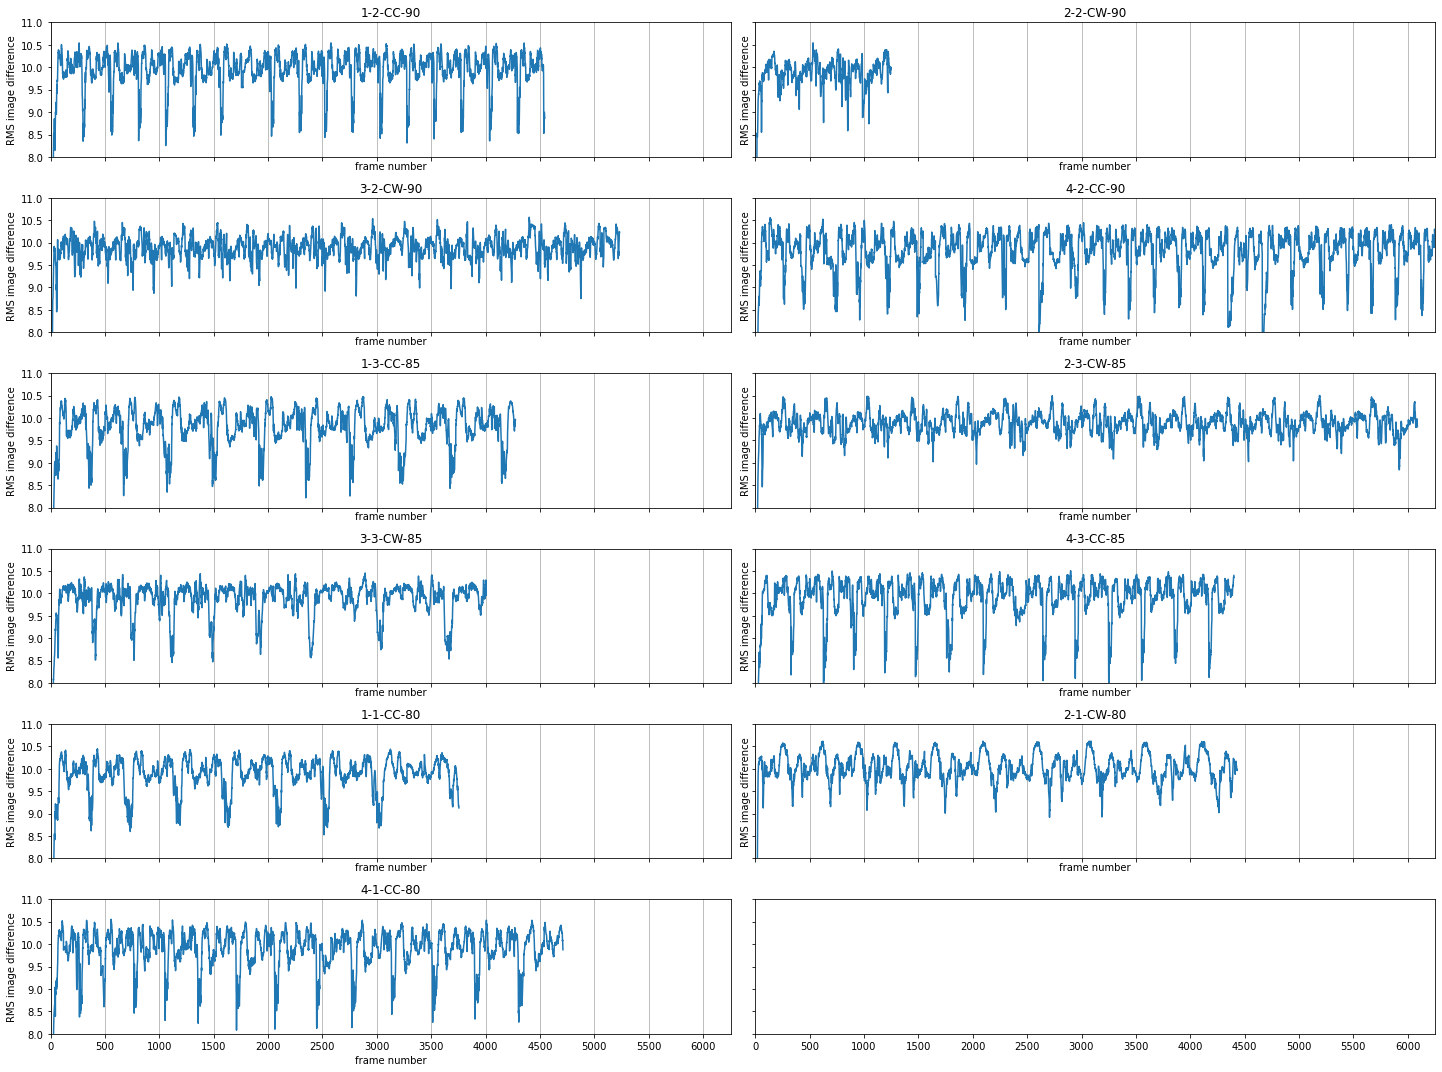

In [11]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [30/2.54, 25/2.54]
fig, axs = plt.subplots(nrows=6, ncols=2, figsize=(20, 15), sharex='all', sharey='all')

for (name, (lower_bound, upper_bound)), ax in zip(tub_bounds, axs.flat):
    images = tub_images[name]
    diffs = get_diffs(images)
    ax.set(title=name, xlabel='frame number', ylabel='RMS image difference')
    ax.grid(True, axis='x')
    ax.plot(diffs)

max_image_counts = max(image_counts)
ax.set(ylim=(8, 11), xlim=(0, max_image_counts), xticks=range(0, max_image_counts, 500))
fig.tight_layout()
plt.show()


### Does the frames-per-lap count differ for different speeds?

In [12]:
from collections import defaultdict

speed_averages = defaultdict(list)

for tubname, lap_average in average_lap_frames.items():
    speed_averages[tubname[-2:]].append(lap_average)
speed_averages

defaultdict(list,
            {'90': [251, 197, 270, 255],
             '85': [414, 422, 456, 297],
             '80': [461, 425, 331]})

In [13]:
{k:int(np.mean(v)) for k,v in speed_averages.items()}

{'90': 243, '85': 397, '80': 405}

### How much data do we have for each speed?

In [14]:
speed_image_count = defaultdict(list)

for tubname, images in tub_images.items():
    print(tubname, len(images))
    speed_image_count[tubname[-2:]].append(len(images))
speed_image_count

1-1-CC-80 3756
2-1-CW-80 4433
4-1-CC-80 4713
1-3-CC-85 4276
2-3-CW-85 6090
3-3-CW-85 4008
4-3-CC-85 4402
1-2-CC-90 4546
2-2-CW-90 1249
3-2-CW-90 5233
4-2-CC-90 6253


defaultdict(list,
            {'80': [3756, 4433, 4713],
             '85': [4276, 6090, 4008, 4402],
             '90': [4546, 1249, 5233, 6253]})

In [15]:
{k: sum(v) for k,v in speed_image_count.items()}

{'80': 12902, '85': 18776, '90': 17281}

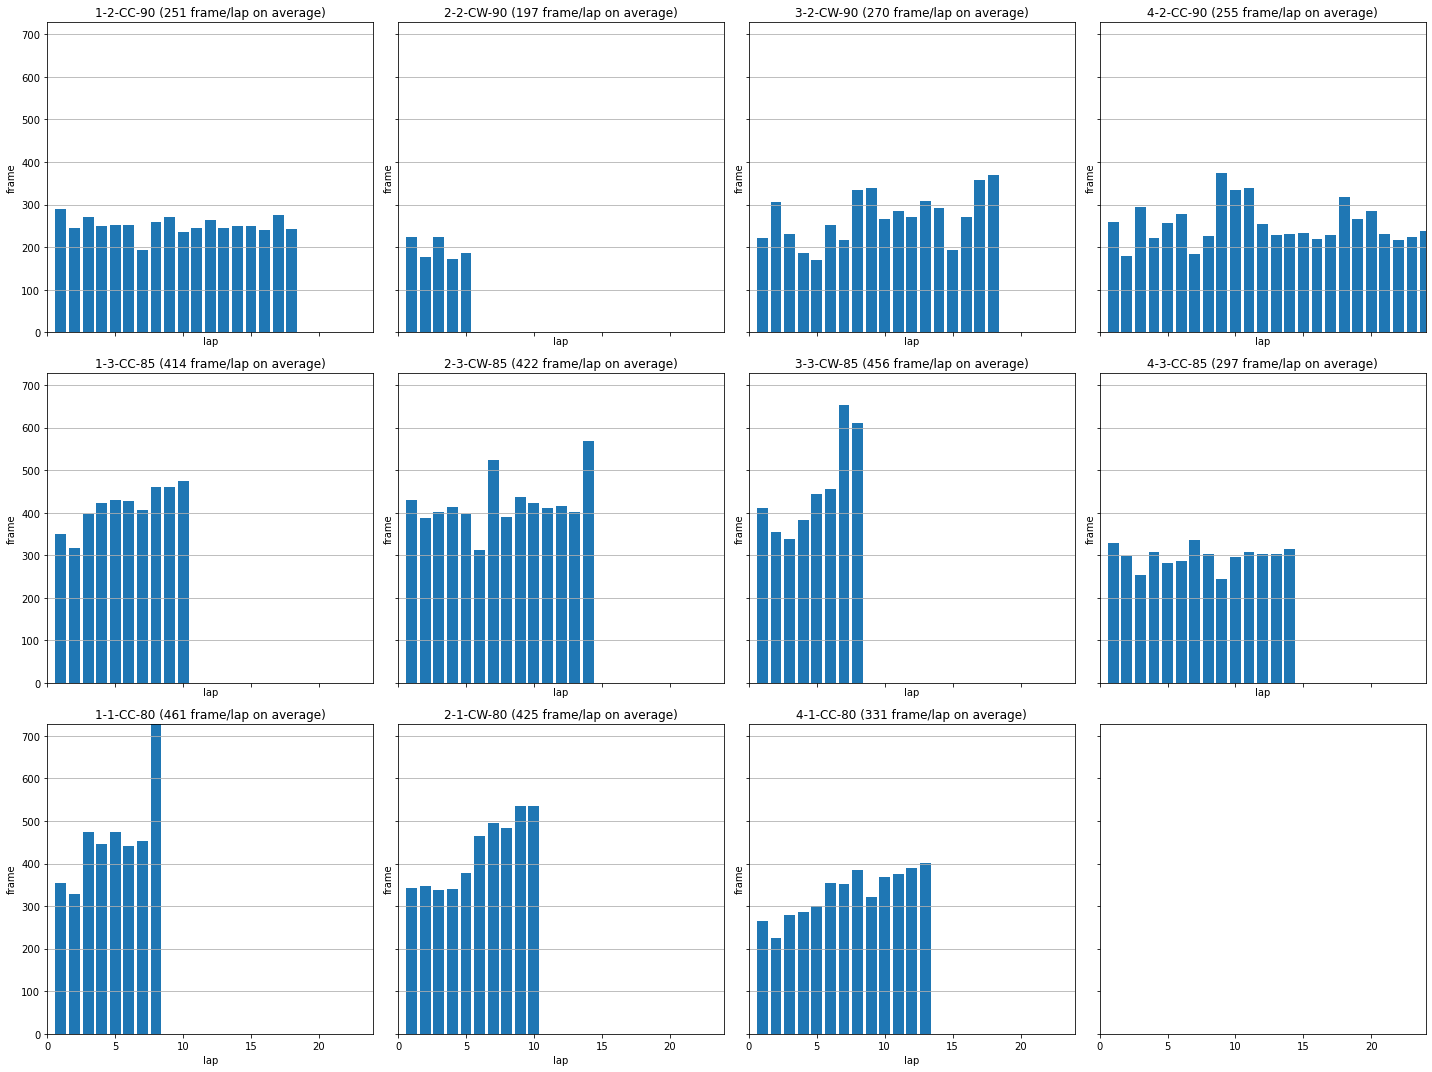

In [16]:
max_frames_per_lap = max([max(tub) for tub in lengths_counts])
max_laps = max([len(tub) for tub in lengths_counts])

fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(20, 15), sharex='all', sharey='all')

for (name, (lower_bound, upper_bound)), ax in zip(tub_bounds, axs.flat):
    images = tub_images[name]
    diffs = get_diffs(images)
    counts = get_counts(diffs, lower_bound, upper_bound)
    lengths = get_lengths(counts)
    ax.grid(True, axis='y')
    ax.set(title=f'{name} ({average_lap_frames[name]} frame/lap on average)', xlabel='lap', ylabel='frame')
    ax.bar(range(1, len(lengths)+1), lengths)

ax.set(ylim=(0, max_frames_per_lap), xlim=(0, max_laps))
fig.tight_layout()
plt.show()

## Are the ground truth turning angles more extreme for with higher speeds?
### Load ground truth angles

In [17]:
tub_angles = {}
for tub_name in tubs:
    angles = [r.underlying['user/angle'] for r in load_records(tub_name, cfg, 'data/')]
    tub_angles[tub_name] = angles

INFO:donkeycar.pipeline.types:Loading tubs from paths ['data/1-1-CC-80']


Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/1-1-CC-80/catalog_4.catalog


INFO:donkeycar.pipeline.types:Loading tubs from paths ['data/2-1-CW-80']


Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/2-1-CW-80/catalog_4.catalog


INFO:donkeycar.pipeline.types:Loading tubs from paths ['data/4-1-CC-80']


Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/4-1-CC-80/catalog_5.catalog


INFO:donkeycar.pipeline.types:Loading tubs from paths ['data/1-3-CC-85']


Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/1-3-CC-85/catalog_4.catalog
Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/2-3-CW-85/catalog_6.catalog


INFO:donkeycar.pipeline.types:Loading tubs from paths ['data/2-3-CW-85']
INFO:donkeycar.pipeline.types:Loading tubs from paths ['data/3-3-CW-85']


Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/3-3-CW-85/catalog_4.catalog


INFO:donkeycar.pipeline.types:Loading tubs from paths ['data/4-3-CC-85']
INFO:donkeycar.pipeline.types:Loading tubs from paths ['data/1-2-CC-90']


Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/4-3-CC-85/catalog_4.catalog
Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/1-2-CC-90/catalog_4.catalog


INFO:donkeycar.pipeline.types:Loading tubs from paths ['data/2-2-CW-90']
INFO:donkeycar.pipeline.types:Loading tubs from paths ['data/3-2-CW-90']


Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/2-2-CW-90/catalog_2.catalog
Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/3-2-CW-90/catalog_6.catalog


INFO:donkeycar.pipeline.types:Loading tubs from paths ['data/4-2-CC-90']


Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/4-2-CC-90/catalog_7.catalog


### How many data points are there per specific direction?

CC - Counter Clockwise and CW - ClockWise
Speeds: 80, 85 and 90

In [18]:
from collections import defaultdict
dir_speed_counts = defaultdict(int)
for k, v in tub_angles.items():
    dir_speed_counts[k[-5:]] += len(v)


dir_speed_counts = list(dir_speed_counts.items())
dir_speed_counts.sort()
dir_speed_counts

[('CC-80', 8469),
 ('CC-85', 8678),
 ('CC-90', 10799),
 ('CW-80', 4433),
 ('CW-85', 10098),
 ('CW-90', 6482)]

Let's demonstrate that higher speeds have more extreme ground truth turning angles.

In [19]:
from collections import OrderedDict
from matplotlib import pyplot as plt

def get_angles_for_direction(tub_angles, direction):
    direction_tub_angles = {k: v for k, v in tub_angles.items() if direction in k}
    direction_tub_angles = OrderedDict(sorted(list(direction_tub_angles.items()), key=lambda k: k[0][-2:]))
    direction_angles_by_speed = OrderedDict()
    for k, v in direction_tub_angles.items():
        if direction_angles_by_speed.get(k[-2:]):
            direction_angles_by_speed[k[-2:]].extend(v)
        else:
            direction_angles_by_speed[k[-2:]] = v
    return direction_angles_by_speed

def plot_all(name, tub_angles):
    plt.figure()
    hist, bins, _ = plt.hist(tub_angles.values(), bins=9, density=True)
    plt.title(name)
    plt.legend(tub_angles.keys())
    plt.xlabel('angle')
    plt.ylabel('count')
    plt.grid()
    plt.show()
    return hist

### Counter clockwise direction histogram

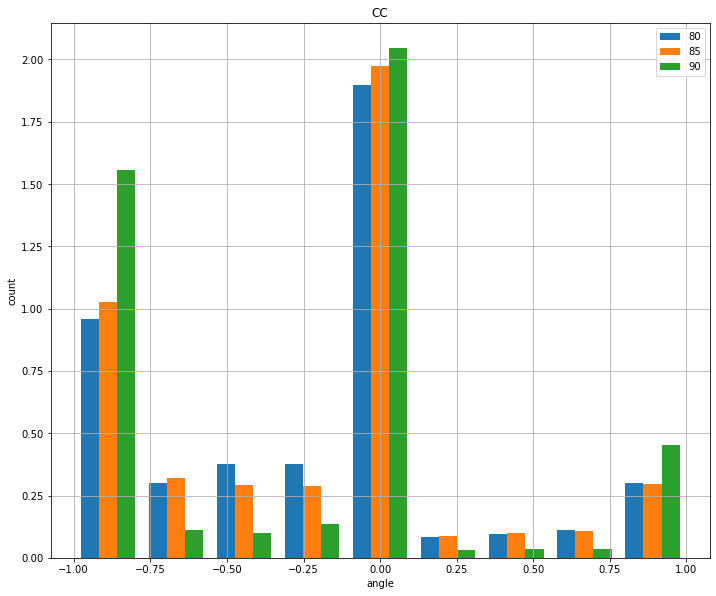

In [20]:
direction = 'CC'
hist = plot_all(direction, get_angles_for_direction(tub_angles, direction))

### Clockwise direction histogram

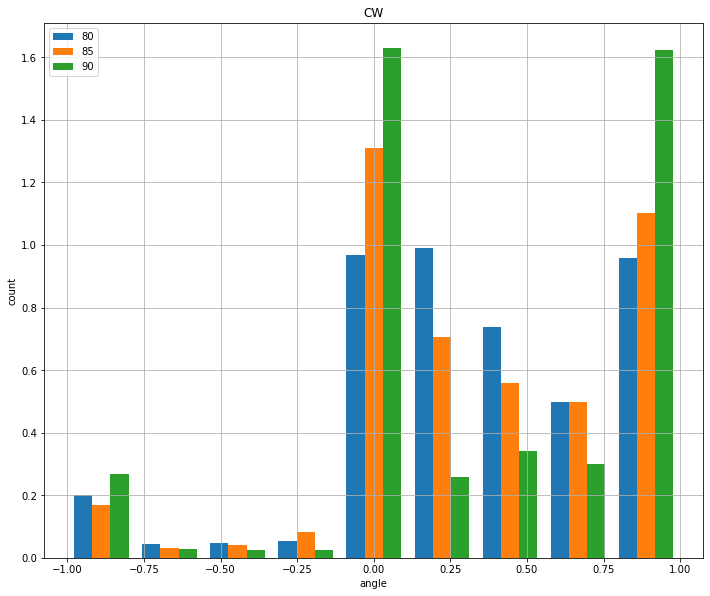

In [21]:
direction = 'CW'
hist = plot_all(direction, get_angles_for_direction(tub_angles, direction))

### On average, do two consecutive images/frames differ more for bigger speeds?

In [22]:

# implement the image diff algo and test it
# plot images diffs
# plot the gt angles and find the range of the number of frames of interest for each speed
# take the images from the ranges found in previous step and plot and focus on their diffs


In [23]:
from skimage.metrics import normalized_root_mse, mean_squared_error
import pandas as pd


for_df = []
for tub_name, images in tub_images.items():
    speed = tub_name[-2:]
    direction = tub_name[-5:-3]
    for i in range(len(images) - 1):
        my_mse = mse(images[i + 1], images[i])
        mse_ = mean_squared_error(images[i + 1], images[i])
        rmse_ = rmse(images[i + 1], images[i])
        nrmse = normalized_root_mse(images[i + 1], images[i])
        for_df.append([tub_name, speed, direction, mse_, rmse_, nrmse, my_mse])

df = pd.DataFrame(for_df, columns=['tub_name', 'speed', 'direction', 'MSE', 'RMSE', 'NRMSE', 'MY_MSE'])
df

,tub_name,speed,direction,MSE,RMSE,NRMSE,MY_MSE
0,1-1-CC-80,80,CC,4.902812,2.206186,0.018518,4.867257
1,1-1-CC-80,80,CC,4.718472,2.168108,0.018177,4.700694
2,1-1-CC-80,80,CC,0.000000,0.000000,0.000000,0.000000
3,1-1-CC-80,80,CC,4.608003,2.141444,0.017965,4.585781
4,1-1-CC-80,80,CC,5.040434,2.225207,0.018787,4.951545
...,...,...,...,...,...,...,...
48943,4-2-CC-90,90,CC,1315.229149,7.058032,0.301984,49.815816
48944,4-2-CC-90,90,CC,911.481771,6.667799,0.251855,44.459549
48945,4-2-CC-90,90,CC,283.165660,5.779378,0.140351,33.401215
48946,4-2-CC-90,90,CC,170.645434,5.674200,0.109022,32.196545


In [24]:
df.groupby('speed').mean()

,MSE,RMSE,NRMSE,MY_MSE
speed,,,,
80,310.237065,5.311199,0.137562,29.136695
85,316.989488,5.291821,0.138806,28.958971
90,471.901552,5.779605,0.168523,34.674183


In [25]:
df.to_csv('image_diffs.csv.gz', index=False)

df.describe()

,MSE,RMSE,NRMSE,MY_MSE
count,48948.000000,48948.000000,48948.000000,48948.000000
mean,369.888814,5.469099,0.148967,31.023084
std,366.968413,1.054543,0.069333,11.448373
min,0.000000,0.000000,0.000000,0.000000
25%,117.711879,4.778838,0.094129,22.837296
50%,248.637778,5.431435,0.139834,29.500486
75%,516.154492,6.146858,0.196989,37.783863
max,8487.999774,10.404927,0.899448,108.262500


In [26]:
import pandas as pd

df = pd.read_csv('image_diffs.csv.gz')

df.groupby('speed').MSE.mean(), df.groupby('speed').RMSE.mean(), df.groupby('speed').NRMSE.mean()

(speed
 80    310.237065
 85    316.989488
 90    471.901552
 Name: MSE, dtype: float64,
 speed
 80    5.311199
 85    5.291821
 90    5.779605
 Name: RMSE, dtype: float64,
 speed
 80    0.137562
 85    0.138806
 90    0.168523
 Name: NRMSE, dtype: float64)

In [27]:
df.describe()


,speed,MSE,RMSE,NRMSE,MY_MSE
count,48948.000000,48948.000000,48948.000000,48948.000000,48948.000000
mean,85.447209,369.888814,5.469099,0.148967,31.023084
std,3.900332,366.968413,1.054543,0.069333,11.448373
min,80.000000,0.000000,0.000000,0.000000,0.000000
25%,80.000000,117.711879,4.778838,0.094129,22.837296
50%,85.000000,248.637778,5.431435,0.139834,29.500486
75%,90.000000,516.154492,6.146858,0.196989,37.783863
max,90.000000,8487.999774,10.404927,0.899448,108.262500


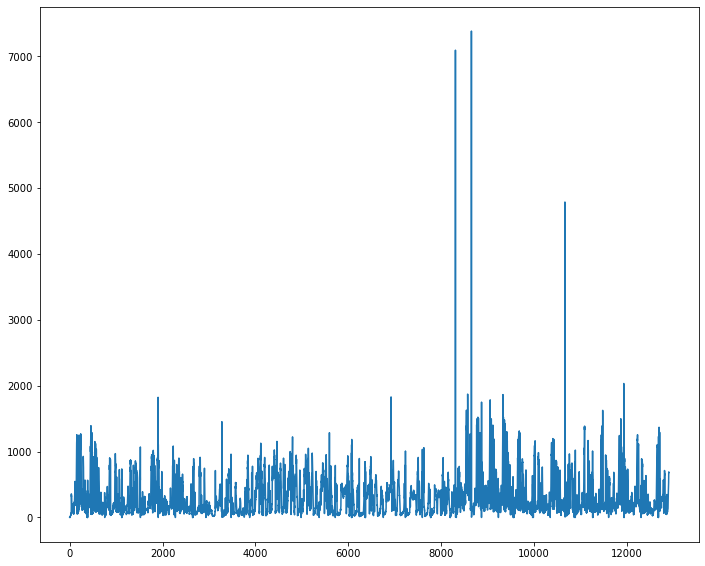

In [28]:
from matplotlib import pyplot as plt
plt.plot(df[df.speed == 80].MSE)


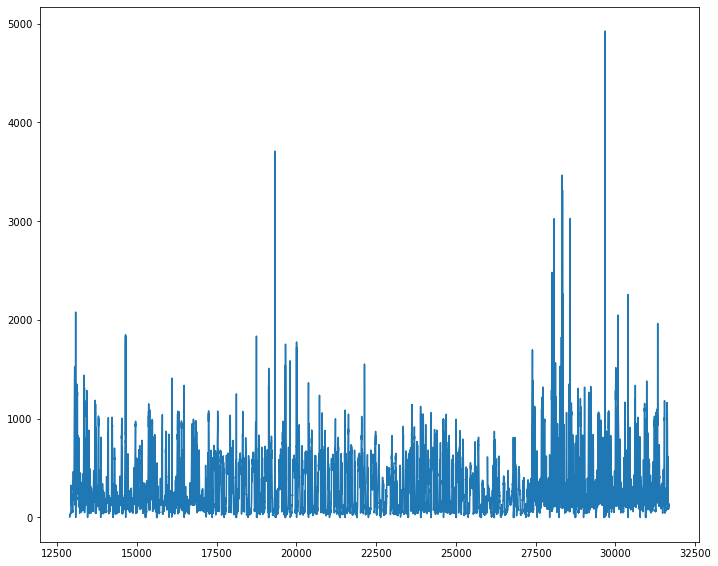

In [29]:
plt.plot(df[df.speed == 85].MSE)


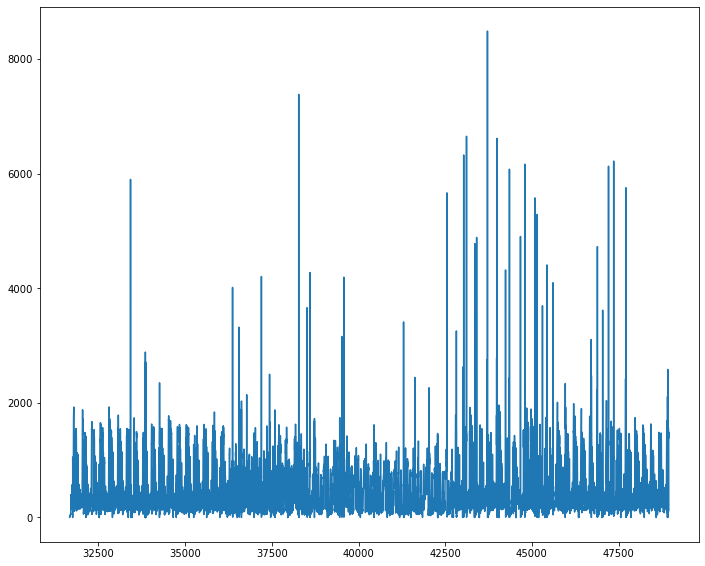

In [30]:
plt.plot(df[df.speed == 90].MSE)


In [31]:
max_mse = df[df.tub_name == '1-1-CC-80'].MSE.max()

df.loc[df.MSE > 2000]

,tub_name,speed,direction,MSE,RMSE,NRMSE,MY_MSE
8305,4-1-CC-80,80,CC,7092.434028,9.912205,0.656224,98.251806
8649,4-1-CC-80,80,CC,7382.429549,10.155819,0.717479,103.140660
10662,4-1-CC-80,80,CC,4787.988056,9.925570,0.644587,98.516944
11929,4-1-CC-80,80,CC,2033.600243,8.081819,0.353758,65.315799
13087,1-3-CC-85,85,CC,2079.507222,7.446737,0.365131,55.453889
...,...,...,...,...,...,...,...
47358,4-2-CC-90,90,CC,6219.162795,9.871762,0.646478,97.451684
47701,4-2-CC-90,90,CC,2423.098472,6.900292,0.410235,47.614028
47710,4-2-CC-90,90,CC,5754.049045,9.650339,0.644998,93.129045
48909,4-2-CC-90,90,CC,2108.957101,8.106060,0.370661,65.708212


### Conclusion



In [32]:
# TODO:
#  treeningandmed uuesti koguda selliselt, et ei oleks lõikamisi, parandusi? Või siis andmed lühemaks teha teha - ehk ei ole nii kulukas?
# Pigem uuesti koguda - arvestades et valget aega on nüüd rohkem.
# Sellised andmed ei sobi ju 3D CNN mudelile ega ka LSTMile. Uuri, kuidas andmete prepp sellised pildid ette valmistab. Pane seq =3 näiteks ja vaata seda indexit, kus ma lõiganud olen. Kas panebki kaks pilti eri kohtadest kõrvuti?!

# Tee oma mse funktsioonile test. Miks sklearn funktsiooniga asendades mul kood ei tööta?
# Leia see lõik, mille peal piltide erinevusi mõõta.

In [37]:
cfg.SEQUENCE_LENGTH = 3
data = load_records('1-2-CC-90', cfg, 'data/')

[r.underlying['_index'] for r in data[0]], [r.underlying['_index'] for r in data[1]],

INFO:donkeycar.pipeline.types:Loading tubs from paths ['data/1-2-CC-90']


Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/1-2-CC-90/catalog_4.catalog


([0, 1, 2], [1, 2, 3])

In [38]:
[r.underlying['_index'] for r in data[1753]], [r.underlying['_index'] for r in data[1754]]

([1753, 1754, 1755], [1856, 1857, 1858])